# Preparation des données
### Initialisation du projet

In [62]:
# imports
import numpy as np
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Importation

In [63]:
import os
import pandas as pd

DATASETS_PATH = os.path.join("C:\Development\Projet-IA\datasets")

def load_datasets_data(dataset_path=DATASETS_PATH):
	csv_general = pd.read_csv(os.path.join(dataset_path, "general_data.csv"))
	csv_manager = pd.read_csv(os.path.join(dataset_path, "manager_survey_data.csv"))
	csv_employee = pd.read_csv(os.path.join(dataset_path, "employee_survey_data.csv"))
	csv_intime = pd.read_csv(os.path.join(dataset_path, "in_time.csv"))
	csv_outtime = pd.read_csv(os.path.join(dataset_path, "out_time.csv"))
	return csv_general, csv_manager, csv_employee, csv_intime, csv_outtime

In [64]:
general_set, manager_set, employee_set, intime_set, outtime_set = load_datasets_data()

In [65]:
dataset_merge = general_set.merge(employee_set.merge(manager_set, on="EmployeeID"), on="EmployeeID")
dataset = dataset_merge.copy()
pd.DataFrame.head(dataset, 5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


### ANOVA / KHI2

In [84]:
# KHI2
import scipy.stats as stats


for name_column in dataset.select_dtypes(include=['object']).columns:
    if (name_column != "Attrition"):
        matrice = pd.crosstab(dataset['Attrition'], dataset[name_column])
        chi2, pvalue,dof, expected = stats.chi2_contingency(matrice)
        print(name_column, "= Statistics : ", chi2, ", p_value : ", pvalue, "\033[32mDépendant\033[0m" if pvalue < 0.05 else "\033[31mIndépendant\033[0m")

BusinessTravel = Statistics :  72.54724105696552 , p_value :  1.764276972983189e-16 Dépendant
Department = Statistics :  29.090274924488266 , p_value :  4.820888218170406e-07 Dépendant
EducationField = Statistics :  46.194921001730584 , p_value :  8.288917469574179e-09 Dépendant
Gender = Statistics :  1.349904410246582 , p_value :  0.24529482862926827 Indépendant
JobRole = Statistics :  25.116313674604072 , p_value :  0.001485544744815264 Dépendant
MaritalStatus = Statistics :  138.49102962254608 , p_value :  8.45385940605786e-31 Dépendant
Over18 = Statistics :  0.0 , p_value :  1.0 Indépendant


In [85]:
#ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
for name_column in dataset.select_dtypes(include=np.number).columns:
    test_anova = name_column + ' ~ Attrition'
    model = ols(test_anova, data=dataset).fit()
    result_anova = sm.stats.anova_lm(model, typ=2)
    print(name_column, "= F : ", result_anova["F"][0], ", p_value : ", result_anova["PR(>F)"][0], "\033[32mDépendant\033[0m" if result_anova["PR(>F)"][0] < 0.05 else "\033[31mIndépendant\033[0m")

Age = F :  78.37222893616206 , p_value :  1.2147714575925333e-18 Dépendant
DistanceFromHome = F :  0.4173697538459805 , p_value :  0.5182860428065224 Indépendant
Education = F :  1.0067851900785003 , p_value :  0.3157293177115451 Indépendant
EmployeeCount = F :  0.038628623616818396 , p_value :  0.8441952900093546 Indépendant
EmployeeID = F :  0.09858538058828525 , p_value :  0.753548740189224 Indépendant
JobLevel = F :  0.46676052333108625 , p_value :  0.4945171727200731 Indépendant
MonthlyIncome = F :  4.288570383801493 , p_value :  0.038427484905952394 Dépendant
NumCompaniesWorked = F :  7.8842127558376305 , p_value :  0.0050088441899783275 Dépendant
PercentSalaryHike = F :  4.670236608422517 , p_value :  0.030743386433316814 Dépendant
StandardHours = F :  0.038628623616818396 , p_value :  0.8441952900093546 Indépendant
StockOptionLevel = F :  0.20617137148426118 , p_value :  0.6498072937492487 Indépendant
TotalWorkingYears = F :  131.45193284104118 , p_value :  5.241246810650881e-3

### Nettoyage des données / Complétion

#### Catégorisation de l'âge

In [66]:
def cat_age(dataframe):
    dataframe.loc[dataframe['Age'] <= 30,'Age'] = 1
    dataframe.loc[(dataframe['Age'] > 30) & (dataframe['Age'] <= 40), 'Age'] = 2
    dataframe.loc[(dataframe['Age'] > 40) & (dataframe['Age'] <= 50), 'Age'] = 3
    dataframe.loc[(dataframe['Age'] > 50) & (dataframe['Age'] <= 60), 'Age'] = 4
    return dataframe

cat_age(dataset); 

In [67]:
dataset.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
mean,2.151020,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,...,11.279936,2.799320,7.008163,2.187755,4.123129,2.723603,2.728246,2.761436,2.729932,3.153741
std,0.920942,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,...,7.782222,1.288978,6.125135,3.221699,3.567327,1.092756,1.101253,0.706245,0.711400,0.360742
min,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,1.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,2.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000
max,4.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


## Test Pipeline	

selection attrition vers y

In [68]:
Attrition = dataset.loc[:, "Attrition"]

In [69]:
dataset_pl = dataset.copy()

useless_value = ['Attrition','StandardHours','Education','EmployeeCount','EmployeeID', "Over18", "Gender", "JobRole", "Department"] 
dataset_pl = dataset_pl.drop(useless_value, axis=1)

ds_num = dataset_pl.select_dtypes(include=[np.number])
ds_str = dataset_pl.select_dtypes(exclude=[np.number])


In [70]:
num_attribs = list(ds_num)
str_attribs = list(ds_str)

dataset_pl

,Age,BusinessTravel,DistanceFromHome,EducationField,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,4,Travel_Rarely,6,Life Sciences,1,Married,131160,1.0,11,0,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,2,Travel_Frequently,10,Life Sciences,1,Single,41890,0.0,23,1,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,2,Travel_Frequently,17,Other,4,Married,193280,1.0,15,3,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,2,Non-Travel,2,Life Sciences,3,Married,83210,3.0,11,3,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,2,Travel_Rarely,10,Medical,1,Single,23420,4.0,12,2,9.0,2,6,0,4,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,3,Travel_Rarely,5,Medical,1,Single,60290,3.0,17,1,10.0,5,3,0,2,4.0,1.0,3.0,3,3
4406,1,Travel_Rarely,2,Medical,1,Divorced,26790,2.0,15,0,10.0,2,3,0,2,4.0,4.0,3.0,2,3
4407,1,Travel_Rarely,25,Life Sciences,2,Married,37020,0.0,20,0,5.0,4,4,1,2,1.0,3.0,3.0,3,4
4408,3,Travel_Rarely,18,Medical,1,Divorced,23980,0.0,14,1,10.0,2,9,7,8,4.0,1.0,3.0,2,3


In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(ds_str)

num_pipeline = Pipeline([
	('imputer', SimpleImputer(strategy="median")), 
	('std_scaler', StandardScaler()),			   
])

pipeline = ColumnTransformer([
	("str_vars", encoder, str_attribs),
	("num_vars", num_pipeline, num_attribs)
])

dataset_pipeline = pipeline.fit_transform(dataset_pl, Attrition)
dataset_pipeline

array([[ 0.        ,  0.        ,  1.        , ..., -1.08533644,
         0.37967213, -0.42623002],
       [ 0.        ,  1.        ,  0.        , ...,  1.75774862,
        -1.02616674,  2.34615106],
       [ 0.        ,  1.        ,  0.        , ..., -2.50687897,
         0.37967213, -0.42623002],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.33620609,
         0.37967213,  2.34615106],
       [ 0.        ,  0.        ,  1.        , ...,  0.33620609,
        -1.02616674, -0.42623002],
       [ 0.        ,  0.        ,  1.        , ...,  0.33620609,
         1.78551099, -0.42623002]])

In [72]:
dataset_prepared = pd.DataFrame(
    dataset_pipeline,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(str_attribs))))
)

In [73]:
dataset_prepared.describe()

,Age,DistanceFromHome,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,...,BusinessTravel_Travel_Rarely,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,...,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03,4.410000e+03
mean,0.102041,0.188435,0.709524,0.018367,0.412245,0.108163,0.315646,0.055782,0.089796,0.222449,...,-4.886492e-17,-2.515499e-16,-8.197021e-17,-2.808285e-17,-1.544746e-16,1.203371e-17,-1.206833e-16,1.906512e-16,-8.161776e-17,-7.776848e-16
std,0.302736,0.391104,0.454034,0.134291,0.492295,0.310622,0.464825,0.229527,0.285922,0.415938,...,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.450719e+00,-2.171982e+00,-1.144294e+00,-6.791457e-01,-1.155935e+00,-1.583120e+00,-1.573999e+00,-2.506879e+00,-2.432006e+00,-4.262300e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.788770e-01,-6.201892e-01,-6.544537e-01,-6.791457e-01,-5.952272e-01,-6.654597e-01,-6.638987e-01,-1.085336e+00,-1.026167e+00,-4.262300e-01
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.643155e-01,1.557071e-01,-3.278933e-01,-3.687153e-01,-3.148735e-01,2.522005e-01,2.462018e-01,3.362061e-01,3.796721e-01,-4.262300e-01
75%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,4.788865e-01,1.557071e-01,3.252275e-01,2.521455e-01,8.065415e-01,1.169861e+00,1.156302e+00,3.362061e-01,3.796721e-01,-4.262300e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.694896e+00,2.483396e+00,5.386914e+00,3.977310e+00,3.610079e+00,1.169861e+00,1.156302e+00,1.757749e+00,1.785511e+00,2.346151e+00


### def x,y

In [74]:
y = pd.get_dummies(Attrition, drop_first=True)
x = dataset_prepared

In [75]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Age                               4410 non-null   float64
 1   DistanceFromHome                  4410 non-null   float64
 2   JobLevel                          4410 non-null   float64
 3   MonthlyIncome                     4410 non-null   float64
 4   NumCompaniesWorked                4410 non-null   float64
 5   PercentSalaryHike                 4410 non-null   float64
 6   StockOptionLevel                  4410 non-null   float64
 7   TotalWorkingYears                 4410 non-null   float64
 8   TrainingTimesLastYear             4410 non-null   float64
 9   YearsAtCompany                    4410 non-null   float64
 10  YearsSinceLastPromotion           4410 non-null   float64
 11  YearsWithCurrManager              4410 non-null   float64
 12  Enviro

In [76]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)

In [77]:
corrmat = X_train.corr() 
corrdf = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))
corrdf = corrdf.unstack().reset_index()
corrdf.columns = ['Var1', 'Var2', 'Correlation']
corrdf.dropna(subset = ['Correlation'], inplace = True)
corrdf['Correlation'] = round(corrdf['Correlation'], 2)
corrdf['Correlation'] = abs(corrdf['Correlation'])
matrix= corrdf.sort_values(by = 'Correlation', ascending = False).head(50)
matrix

C:\Users\Kvendev\AppData\Local\Temp/ipykernel_4640/2583708761.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corrdf = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))


,Var1,Var2,Correlation
829,MaritalStatus_Single,BusinessTravel_Non-Travel,0.78
688,EducationField_Medical,EducationField_Life Sciences,0.77
59,JobLevel,DistanceFromHome,0.75
563,BusinessTravel_Travel_Rarely,EnvironmentSatisfaction,0.64
329,YearsWithCurrManager,YearsSinceLastPromotion,0.63
628,EducationField_Life Sciences,BusinessTravel_Travel_Rarely,0.63
659,EducationField_Marketing,EducationField_Life Sciences,0.61
178,StockOptionLevel,NumCompaniesWorked,0.57
58,JobLevel,Age,0.53
689,EducationField_Medical,EducationField_Marketing,0.50


### Regression Logistique

In [78]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
#"newton-cg", "lbfgs", "liblinear", "sag", "saga"
lr = LogisticRegression(solver="liblinear", max_iter=1000)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)


K:\Users\Kvendev\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Indicateurs de qualité

In [79]:
print("Accuracy score : ", accuracy_score(y_test,y_pred))
print("Matrice de confusion :")
print(confusion_matrix(y_test,y_pred))

Accuracy score :  0.8510959939531368
Matrice de confusion :
[[1095   15]
 [ 182   31]]


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      1110
           1       0.67      0.15      0.24       213

    accuracy                           0.85      1323
   macro avg       0.77      0.57      0.58      1323
weighted avg       0.83      0.85      0.81      1323



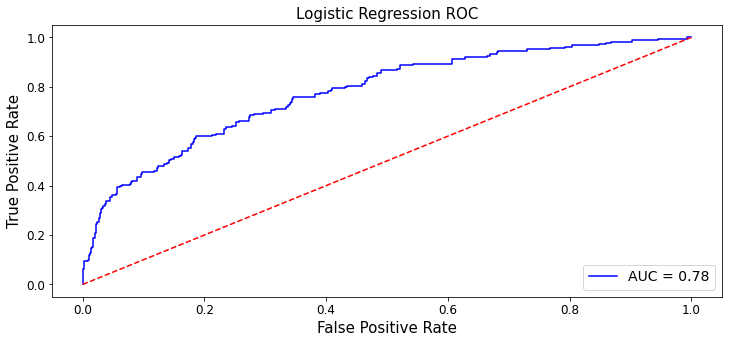

In [81]:
from sklearn import metrics

plt.figure(figsize=(12,5))

lrprob = lr.predict_proba(X_test)
lr_pred = lrprob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, lr_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('Logistic Regression ROC', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend(loc = 'lower right', prop={'size': 14})

plt.show()
